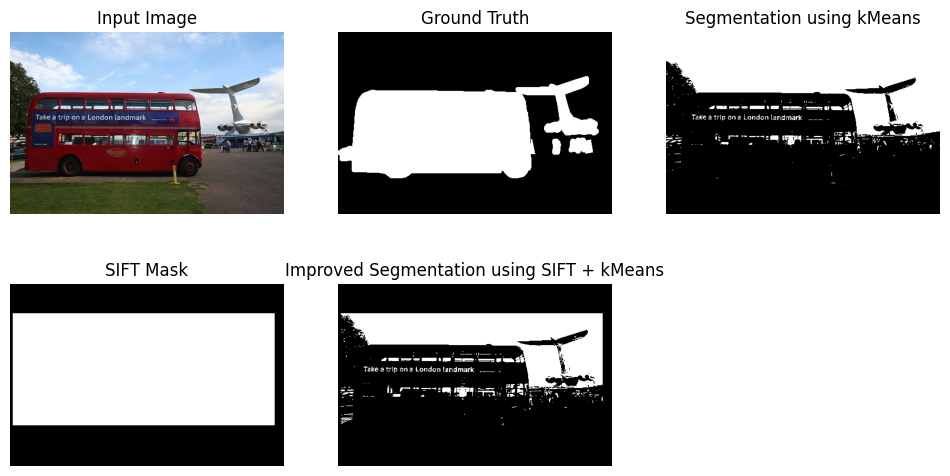

IoU for Segmentation using kMeans: 0.06296737647444865
IoU for Improved Segmentation kMeans + SIFT: 0.09514209910442227


In [26]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage import io
import warnings
warnings.filterwarnings("ignore")


def calculate_IoU(mask1, mask2):
    intersec = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    score = np.sum(intersec) / np.sum(union)
    return score

# Load Image from VOC 2012 dataset
input_image = io.imread('/content/sample_data/2007_000648.jpg')
gt_image = io.imread('/content/sample_data/2007_000648.png')

# Convert the image to grayscale
gray_image = cv2.cvtColor(gt_image, cv2.COLOR_RGB2GRAY)
_, gt_image_mask = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)

# Basic K-means segmentation
image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
# Reshape the image to a 2D array of pixels
pixels = image_rgb.reshape((-1, 3))
# Apply K-means clustering
n_clusters =2
#Define your own initial centroids
init_cent = np.array([[0, 0, 0], [50, 100, 200]])  # Example initial centroids
kmeans = KMeans(n_clusters=n_clusters, init=init_cent, n_init=1)
kmeans.fit(pixels)
segmented_img = kmeans.labels_.reshape(input_image.shape[:2]).astype(np.uint8) == 1

#Improved segmentation using SIFT
gray_img = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

# Applying SIFT detector
sift = cv2.SIFT_create()
kp = sift.detect(gray_img, None)
#print(len(kp))
#print(kp[0].pt)

# Sort keypoints based on their response (strength)
keypoints = sorted(kp, key=lambda x: x.response, reverse=True)

# Keep only the top 100 strong keypoints
strong_keypoints = keypoints[:int(len(kp)/2)]
#strong_keypoints = kp

min_x = gray_img.shape[0]
min_y = gray_img.shape[1]
max_x=0
max_y=0
# loop over the contours
for i in range(len(strong_keypoints)-1):
  (x,y) = strong_keypoints[i].pt
  x = int(x)
  y = int(y)
  if(x < min_x):
    min_x = x
  if(y < min_y):
    min_y = y
  if(x > max_x):
    max_x = x
  if(y > max_y):
    max_y = y

#create mask from SIFT feature points
sift_mask = np.zeros_like(gray_img)
sift_mask[min_y:max_y+1, min_x:max_x+1] = 255
sift_mask =cv2.cvtColor(sift_mask,cv2.COLOR_GRAY2RGB)


image_rgb = cv2.bitwise_and(image_rgb, sift_mask)
# Reshape the image to a 2D array of pixels
input_SIFT = image_rgb.reshape((-1, 3))
SIFT_kmeans = KMeans(n_clusters=2, init=init_cent, n_init=1)
SIFT_kmeans.fit(input_SIFT)
SIFT_segmented_img_mask = SIFT_kmeans.labels_.reshape(image_rgb.shape[:2]).astype(np.uint8) == 1


# Calculate IoU for segmentation using kMeans
kMeans_IoU = calculate_IoU(segmented_img, gt_image_mask)

# Calculate IoU for segmentation using kMeans + SIFT features
SIFT_IoU = calculate_IoU(SIFT_segmented_img_mask, gt_image_mask)

# Display the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(gt_image_mask, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')


plt.subplot(2, 3, 3)
plt.imshow(segmented_img.astype(np.uint8), cmap='gray')
plt.title('Segmentation using kMeans')
plt.axis('off')


plt.subplot(2, 3, 4)
plt.imshow(sift_mask,  cmap='gray')
plt.title('SIFT Mask')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(SIFT_segmented_img_mask, cmap='gray')
plt.title('Improved Segmentation using SIFT + kMeans')
plt.axis('off')
plt.show()


# Print IoU scores
print("IoU for Segmentation using kMeans:", kMeans_IoU)
print("IoU for Improved Segmentation kMeans + SIFT:", SIFT_IoU)